**Abstract**

This notebook studies weather selfish behavior of users on the Lightning Network leeds to a depleted network state similar to [globaly optimizing the fee potential](https://github.com/renepickhardt/Lightning-Network-Limitations/blob/sidiropoulos_counter_example/Limits%20of%20two%20party%20channels/Estimating%20Liquidity%20State%20given%20Fees%20and%20Network%20Topologies.ipynb). It also tests if the location of the spanning tree that emerges from selfish behavior is similar to the location of the spanning tree that comes fromt he global optimization problem of maximizing the fee potential

We define two key classes: `LiquidityGraph` and `ChannelGraph`. `LiquidityGraph` represents a directed graph where edges indicate liquidity (funds) that flow between nodes, along with associated fees. `ChannelGraph` is derived from `LiquidityGraph` and represents an undirected, aggregated view of available liquidity channels, where each edge has a specified capacity. Additionally, the `LiquidityGraph` class includes various methods for payment simulation, wealth distribution analysis, and fee potential maximization.

The core functionality of this program includes generating a random bipartite `LiquidityGraph`, conducting simulated payments to model liquidity flow, and calculating metrics such as wealth distribution and [fee potential](https://github.com/DerEwige/speedupln.com/blob/main/docs/fee_potential_and_rebalancing.md). This choice is motivated by recent research results that inidicate that [bipartite networks are a reasonable choice for approximations to cost optimal network topologies](https://pubsonline.informs.org/doi/10.1287/mnsc.2023.03872). A key feature is the optimization function that, given a target `ChannelGraph` and a specified wealth distribution, computes a new `LiquidityGraph` configuration with the same channel structure that maximizes potential fee income. This optimization process is formulated as an integer linear programming problem and solved using `scipy.optimize.linprog`.

**Results**
It seems that users conducting payments will quickly depleted most channels but a spanning tree and that the resulting liquidity network has a fee potential that is very close (~97%) to the one that one gets if globally solving the optimization problem of maximizing the networks fee potential. 

Also the strong correlation with the MAD suggests that the location of the spanning tree from the global optimization problem is very similar to the location of the spanning tree that emerges from conducting payments. 

Thus the global optimization problem can be used to estimate where liquidity is located (assuming one knows the prior wealth distribution)

**Limitations**
* payment pairs are selected randomly
* payment amounts are selected uniformly up to max_flow
* Network size cannot realistically exceed LN's size if reasonable runtime is required
* Only a linear cost function (representing ppm) was selcted
* topology one of a random network not scale free / routing fees / capacities not realistic

**Future work**
1. Besides including a more precise cost function a divergence of observed liquidity to the predicted one may give a clue about the actual wealth distribution of the network. Not sure how strong the signal is though. Similarly this might be useful to get rid of uniform payment pair assumption.
2. Is it better (as in max flow distribution shifts to the right) if nodes would allocate all the depleted liquidity into the spanning tree and the network would only be the spanning tree

**Acknowledgement**
 The work is sponsored through a [grant from OpenSats](https://opensats.org/blog/rene-pickhardt-receives-lts-grant) and through [individual patreons](https://www.patreon.com/renepickhardt).

**Disclaimer**
Most of the code for this notebook was generated with the assistance of ChatGPT.

In [36]:
from scipy.optimize import linprog
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import Counter

In [42]:
class ChannelGraph:
    def __init__(self):
        # Initialize an undirected graph
        self.graph = nx.Graph()

    def add_edge(self, node1, node2, capacity, fees=None):
        """
        Adds an undirected edge between node1 and node2 with specified capacity and fees.
        
        Parameters:
            node1: The first node.
            node2: The second node.
            capacity: The capacity of the edge.
            fees: A dictionary assigning an integer fee to each node on the edge.
                  Should be in the form {node1: fee1, node2: fee2}.
        """
        if fees is None:
            fees = {node1: 0, node2: 0}
        self.graph.add_edge(node1, node2, capacity=capacity, fees=fees)

    def total_capacity(self, node):
        """
        Returns the total capacity accessible to the specified node, 
        which is the sum of capacities of edges connected to it.
        
        Parameters:
            node: The node for which to calculate the total accessible capacity.
        
        Returns:
            float: The total capacity of the node.
        """
        if node not in self.graph:
            raise ValueError(f"Node {node} is not in the graph.")
        
        # Sum the capacity of all edges connected to the node
        return sum(data['capacity'] for _, _, data in self.graph.edges(node, data=True))

    def get_fee(self, node1, node2):
        """
        Returns the fee for node1 to access node2 on a given edge.
        
        Parameters:
            node1: The node from which we want the fee.
            node2: The node to which the fee is being charged.
        
        Returns:
            int: The fee for node1 to access node2 on this edge, if the edge exists.
                 Returns None if the edge does not exist.
        """
        if self.graph.has_edge(node1, node2):
            return self.graph[node1][node2]['fees'].get(node1, 0)
        else:
            raise ValueError(f"No edge exists between {node1} and {node2}")


class LiquidityGraph:
    def __init__(self):
        # Initialize a directed graph
        self.graph = nx.DiGraph()

    def add_edge(self, node1, node2, liquidity, fee=0):
        """
        Adds a directed edge from node1 to node2 with specified liquidity and fee.
        
        Parameters:
            node1: The starting node.
            node2: The ending node.
            liquidity: The liquidity of the edge.
            fee: The fee for accessing this edge from node1 to node2.
        """
        self.graph.add_edge(node1, node2, liquidity=liquidity, fee=fee)

    def to_channel_graph(self):
        """
        Converts the directed LiquidityGraph into an undirected ChannelGraph.
        
        Returns:
            ChannelGraph: The undirected graph representation.
        """
        channel_graph = ChannelGraph()

        # Iterate over all pairs of nodes with edges in the LiquidityGraph
        for node1, node2 in self.graph.edges():
            # Get liquidity in both directions, if they exist
            liquidity_1_to_2 = self.graph[node1][node2].get('liquidity', 0)
            liquidity_2_to_1 = self.graph[node2][node1].get('liquidity', 0) if self.graph.has_edge(node2, node1) else 0

            # Calculate total capacity for the undirected edge
            total_capacity = liquidity_1_to_2 + liquidity_2_to_1

            # Set fees for each direction
            fees = {
                node1: self.graph[node1][node2].get('fee', 0),
                node2: self.graph[node2][node1].get('fee', 0) if self.graph.has_edge(node2, node1) else 0
            }

            # Add the undirected edge to the ChannelGraph
            channel_graph.add_edge(node1, node2, capacity=total_capacity, fees=fees)

        return channel_graph

    def make_payment(self, sender, receiver, amount=None):
        """
        Executes a payment from sender to receiver.
        
        Parameters:
            sender: The node initiating the payment.
            receiver: The node receiving the payment.
            amount: The amount to be transferred. If None, a random amount is selected 
                    between 0 and the maximum flow from sender to receiver.
                    
        Returns:
            bool: True if the payment was successful, False otherwise.
        """
        # Check if sender and receiver are in the graph
        if sender not in self.graph or receiver not in self.graph:
            raise ValueError("Both sender and receiver must be nodes in the graph.")

        # Calculate the maximum flow from sender to receiver
        max_flow_value, _ = nx.maximum_flow(self.graph, sender, receiver, capacity='liquidity')
        #print(max_flow_value)
        # If an amount is specified, ensure it doesn't exceed max flow
        if amount is not None:
            if amount > max_flow_value:
                print("Payment failed: Amount exceeds max flow.")
                return False
        else:
            if max_flow_value<1:
                print("Payment failed: No feasible flow from ({}) to ({}) possible".format(sender,receiver))
                return False
                
            # Select a random amount between 0 and max flow if no amount is given
            amount = random.randint(1, max_flow_value)

        # Create a copy of the graph with 'cost' attribute based on fees for min-cost flow calculation
        flow_graph = nx.DiGraph()
        flow_graph.add_node(sender, demand=-amount)
        flow_graph.add_node(receiver, demand=amount)
        for u, v, data in self.graph.edges(data=True):
            if data['liquidity'] > 0:
                flow_graph.add_edge(u, v, capacity=data['liquidity'], weight=data['fee'],demand="demand")
        
        # Calculate the min-cost flow to send the `amount` from sender to receiver
        min_cost_flow_dict = nx.min_cost_flow(flow_graph)
        #print(min_cost_flow_dict)

        # Execute the payment by updating the liquidity on the edges
        for u, dests in min_cost_flow_dict.items():
            #print(u,dests)
            for v,flow_amount in dests.items(): 
                #flow_amount = min_cost_flow_dict[u][v]
                if flow_amount > 0:
                    # Deduct the flow amount from u -> v
                    #print(u,v,flow_amount)
                    self.graph[u][v]['liquidity'] -= flow_amount
                    # Increase the reverse edge v -> u liquidity by flow amount
                    if self.graph.has_edge(v, u):
                        self.graph[v][u]['liquidity'] += flow_amount
                    else:
                        # If the reverse edge doesn't exist, create it with initial liquidity of flow_amount
                        self.graph.add_edge(v, u, liquidity=flow_amount, fee=self.graph[u][v]['fee'])

        #print(f"Payment of {amount} from {sender} to {receiver} was successful.")
        return True

    def edge_relative_liquidity(self):
        """
        Creates a list where each entry is the relative liquidity of an edge
        in comparison to the total liquidity of the edge and its opposite direction.
        
        Returns:
            List[Tuple[Tuple[node, node], float]]: A list of tuples where each tuple 
            contains the edge (node1, node2) and its relative liquidity as a float.
        """
        relative_liquidity_list = []
    
        for u, v, data in self.graph.edges(data=True):
            # Liquidity of the edge (u, v)
            liquidity_uv = data.get('liquidity', 0)
            
            # Liquidity of the edge (v, u) if it exists, otherwise 0
            liquidity_vu = self.graph[v][u].get('liquidity', 0) if self.graph.has_edge(v, u) else 0
            
            # Total liquidity in both directions
            total_liquidity = liquidity_uv + liquidity_vu
    
            # Calculate relative liquidity (avoid division by zero)
            if total_liquidity > 0:
                relative_liquidity = liquidity_uv / total_liquidity
            else:
                relative_liquidity = 0.0
            
            # Append to list in format (relative_liquidity)
            relative_liquidity_list.append(((u,v),relative_liquidity))
    
        return relative_liquidity_list

    def fee_potential(self):
        """
        Computes the fee potential of the liquidity graph.
        The fee potential is the sum over all edges where each edge's fee potential
        is defined as the product of its liquidity and fee.
    
        Returns:
            float: The total fee potential of the graph.
        """
        total_fee_potential = 0
    
        for u, v, data in self.graph.edges(data=True):
            liquidity = data.get('liquidity', 0)
            fee = data.get('fee', 0)
            
            # Calculate the fee potential for this edge and add to total
            total_fee_potential += liquidity * fee
    
        return total_fee_potential
    
    def wealth_distribution(self):
        """
        Calculates the wealth distribution as the total liquidity for each node.
        
        Returns:
            dict: A dictionary where keys are nodes and values are the sum of outgoing
                  liquidity values for each node.
        """
        distribution = {}
        for node in self.graph.nodes():
            total_liquidity = sum(data['liquidity'] for _, _, data in self.graph.out_edges(node, data=True))
            distribution[node] = total_liquidity
        return distribution

    def compare_relative_liquidity_mad(self, other_graph):
        """
        Compares the relative liquidity values of each edge between this liquidity graph 
        and another liquidity graph using the Mean Absolute Difference (MAD) method.
        
        Only edges present in both graphs are considered in the calculation.
        
        Parameters:
            other_graph (LiquidityGraph): The other liquidity graph to compare with.
            
        Returns:
            float: The Mean Absolute Difference (MAD) between the relative liquidity values
                   of the edges in both graphs.
        """
        # Get relative liquidity values for each edge in both graphs
        self_relative_liquidity = dict(self.edge_relative_liquidity())
        other_relative_liquidity = dict(other_graph.edge_relative_liquidity())
        
        # Initialize variables for MAD calculation
        total_difference = 0
        count = 0
        
        # Iterate over edges in the first graph
        for edge, self_liquidity in self_relative_liquidity.items():
            # Check if the edge is also in the other graph
            if edge in other_relative_liquidity:
                # Calculate the absolute difference in relative liquidity for this edge
                other_liquidity = other_relative_liquidity[edge]
                total_difference += abs(self_liquidity - other_liquidity)
                count += 1
        
        # Return the mean absolute difference
        return total_difference / count if count > 0 else 0

    def sample_maxflow_cdf(self, sample_size=100):
        """
        Computes an approximate cumulative distribution function (CDF) of max-flow values
        by sampling a random subset of node pairs.
    
        Parameters:
            sample_size (int): The number of random (source, target) pairs to sample.
        
        Returns:
            list of tuples: A list of tuples where the first element is a max-flow value 
                            and the second element is the corresponding cumulative probability.
        """
        # Get all nodes in the graph
        nodes = list(self.graph.nodes)
        num_nodes = len(nodes)
        
        # Ensure the sample size does not exceed the total number of unique pairs
        max_possible_pairs = num_nodes * (num_nodes - 1)
        actual_sample_size = min(sample_size, max_possible_pairs)
        
        # Sample unique (source, target) pairs
        sampled_pairs = set()
        while len(sampled_pairs) < actual_sample_size:
            source, target = random.sample(nodes, 2)
            sampled_pairs.add((source, target))
        
        # Compute max-flow for each sampled pair and store results
        # taken from `evaluate_samples` at:
        # https://github.com/renepickhardt/Lightning-Network-Limitations/blob/main/likelihood-of-payment-possability/An%20upper%20Bound%20for%20the%20Probability%20to%20be%20able%20to%20successfully%20conduct%20a%20Payment%20on%20the%20Lightning%20Network.ipynb
        max_flows = []
        for source, target in sampled_pairs:
            flow_value, _ = nx.maximum_flow(self.graph, source, target, capacity='liquidity')
            max_flows.append(flow_value)

        c=Counter(max_flows)
        trials = len(max_flows)
        successes = trials
        x_values = []
        y_values = []
        for x,frequency in sorted(c.items()):
            successes -= frequency
            x_values.append(x)
            y_values.append(successes/trials)
        return x_values, y_values
    
    def print_liquidity(self):
        for src,dest,data in self.graph.edges(data=True):
            print(src,dest,data)



In [6]:
def optimize_liquidity_graph(liquidity_graph):
    """
    Given a liquidity graph, its resulting channel graph, and the wealth distribution,
    compute a new liquidity graph with the same channel graph and wealth distribution
    that maximizes the fee potential.
    
    Parameters:
        liquidity_graph (LiquidityGraph): The initial liquidity graph.
    
    Returns:
        LiquidityGraph: A new LiquidityGraph with maximum fee potential.
    """
    channel_graph = liquidity_graph.to_channel_graph() 
    wealth_distribution = liquidity_graph.wealth_distribution()
    
    # Step 1: Collect the variables and mappings for constraints
    edges = list(liquidity_graph.graph.edges(data=True))
    edge_index_map = {edge[:2]: i for i, edge in enumerate(edges)}

    num_edges = len(edges)
    fees = np.array([data['fee'] for _, _, data in edges])
    
    # Step 2: Define the objective function (maximize fee potential)
    # Objective: max sum of (fee_uv * liquidity_uv) for each edge (u, v)
    # In scipy's linprog, we minimize, so we use -fees
    c = -fees  # Negate because linprog does minimization by default

    # Step 3: Define the constraints
    # Capacity constraints for each undirected edge in the ChannelGraph
    A_eq = []
    b_eq = []

    for u, v, data in channel_graph.graph.edges(data=True):
        capacity = data['capacity']
        row = np.zeros(num_edges)
        row[edge_index_map[(u, v)]] = 1  # liquidity_uv
        row[edge_index_map[(v, u)]] = 1  # liquidity_vu
        A_eq.append(row)
        b_eq.append(capacity)

    # Wealth distribution constraints for each node
    for node, target_wealth in wealth_distribution.items():
        row = np.zeros(num_edges)
        for neighbor in liquidity_graph.graph.successors(node):
            row[edge_index_map[(node, neighbor)]] = 1  # outgoing edge
        A_eq.append(row)
        b_eq.append(target_wealth)

    # Convert lists to numpy arrays for linprog
    A_eq = np.array(A_eq)
    b_eq = np.array(b_eq)

    # Step 4: Define bounds for each variable (liquidity values are non-negative integers)
    bounds = [(0, None) for _ in range(num_edges)]

    # Step 5: Solve the linear program
    result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if result.success:
        # Step 6: Create the new optimized LiquidityGraph
        optimized_liquidity_graph = LiquidityGraph()
        for (u, v, _), liquidity in zip(edges, result.x):
            # Round liquidity to integer for integer constraints
            optimized_liquidity_graph.add_edge(u, v, liquidity=int(round(liquidity)), fee=liquidity_graph.graph[u][v]['fee'])
        return optimized_liquidity_graph
    else:
        print("Optimization failed:", result.message)
        return None

In [70]:
def create_random_bipartite_liquidity_graph(n, m, liquidity_range=(100_000, 1000_000), fee_range=(100, 1000)):
    """
    Creates a random bipartite LiquidityGraph.
    
    Parameters:
        n (int): Total number of nodes.
        m (int): Number of edges to be added.
        liquidity_range (tuple): Range for random liquidity values (min, max).
        fee_range (tuple): Range for random fee values (min, max).
    
    Returns:
        LiquidityGraph: The generated bipartite liquidity graph.
    """
    # Create a bipartite graph using NetworkX
    # Split nodes into two groups to ensure bipartiteness
    left_nodes = set(range(n // 2))
    right_nodes = set(range(n // 2, n))

    graph = LiquidityGraph()
    # Add additional random edges between left and right nodes up to m edges
    additional_edges = m 
    while additional_edges > 0:
        u = random.choice(list(left_nodes))
        v = random.choice(list(right_nodes))
        if not graph.graph.has_edge(u, v):
            liquidity = random.randint(*liquidity_range)
            fee = random.randint(*fee_range)
            graph.add_edge(u, v, liquidity=liquidity, fee=fee)
            liquidity = random.randint(*liquidity_range)
            fee = random.randint(*fee_range)
            graph.add_edge(v, u, liquidity=liquidity, fee=fee)

            additional_edges -= 1

    return graph


def conduct_random_payments(graph, num_payments):
    """
    Conducts a series of random payments between two randomly chosen nodes in the LiquidityGraph.
    
    Parameters:
        graph (LiquidityGraph): The liquidity graph where payments will be conducted.
        num_payments (int): Number of random payments to conduct.
    """
    nodes = list(graph.graph.nodes())
    for _ in range(num_payments):
        sender, receiver = random.sample(nodes, 2)  # Choose two different nodes
        success = graph.make_payment(sender, receiver)  # Try to make a random payment
        if not success:
            print(f"Payment from {sender} to {receiver} failed.")




In [72]:
n = 100
m = 400
num_payments = 1

# Generate the random bipartite LiquidityGraph
liquidity_graph = create_random_bipartite_liquidity_graph(n, m)

print("sampling max flow values")
x,cdf = liquidity_graph.sample_maxflow_cdf(500)
print("done")

fp = []
cr = []
dist = []
for i in range(500):
    tmp = optimize_liquidity_graph(liquidity_graph)
    opt = tmp.fee_potential()
    dist.append(liquidity_graph.compare_relative_liquidity_mad(tmp))
    fp.append(liquidity_graph.fee_potential()/opt)
    relative_liquidity = [x[1] for x in liquidity_graph.edge_relative_liquidity()]
    cr.append(len([x for x in relative_liquidity if x==1.0])/(m-n))
    #plt.hist(relative_liquidity,bins=100,cumulative=True,histtype="step")
    conduct_random_payments(liquidity_graph, num_payments)
    if i%50==0:
        print(i)
# Display final wealth distribution after payments
relative_liquidity = [x[1] for x in liquidity_graph.edge_relative_liquidity()]
#plt.hist(relative_liquidity,bins=100,cumulative=True,histtype="step")
#plt.grid()
#plt.xlabel("relative liquidity")
#plt.ylabel("number of edges")
#plt.xlim(0,0.5)
#plt.show()

print("sampling max flow values")
x2,cdf2 = liquidity_graph.sample_maxflow_cdf(500)
print("done")

#print("Final Wealth Distribution:", final_wealth_dist)


sampling max flow values
done
0
50
100
150
200
250
300
350
400
450
sampling max flow values
done


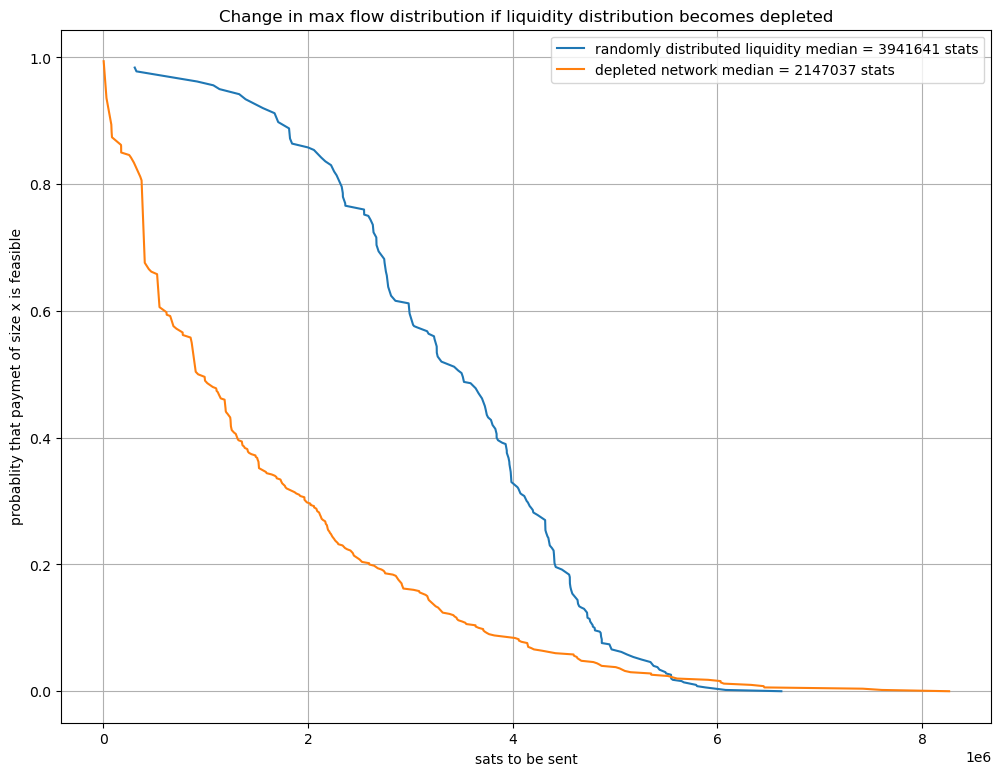

In [86]:
plt.figure(figsize=(12,9))
plt.title("Change in max flow distribution if liquidity distribution becomes depleted")
plt.plot(x,cdf,label = "randomly distributed liquidity median = {} stats".format(int(np.median(x))))
plt.plot(x2,cdf2,label = "depleted network median = {} stats".format(int(np.median(x2))))
plt.grid()
plt.xlabel("sats to be sent")
plt.ylabel("probablity that paymet of size x is feasible")
plt.legend()
plt.show()

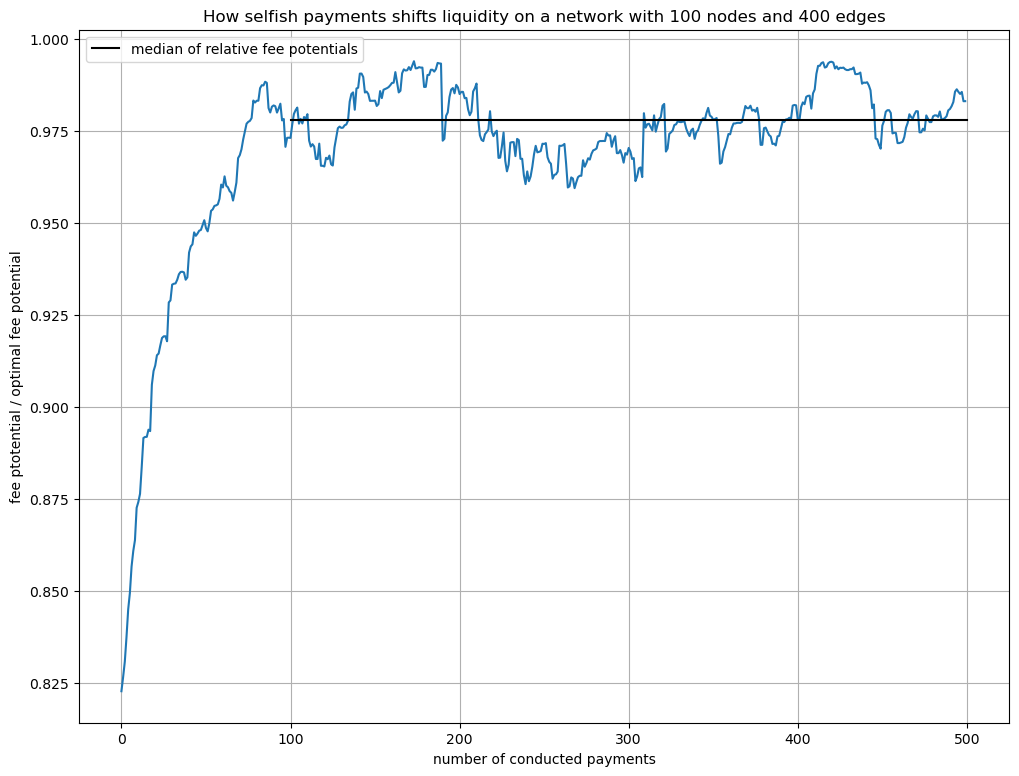

In [76]:
plt.figure(figsize=(12,9))
plt.title("How selfish payments shifts liquidity on a network with {} nodes and {} edges".format(n,m))
plt.plot(fp)
plt.plot([100,500],[np.mean(fp[100:]),np.mean(fp[100:])],"k-",label="median of relative fee potentials")
plt.grid()
plt.legend()
plt.ylabel("fee ptotential / optimal fee potential")
plt.xlabel("number of conducted payments")
plt.show()

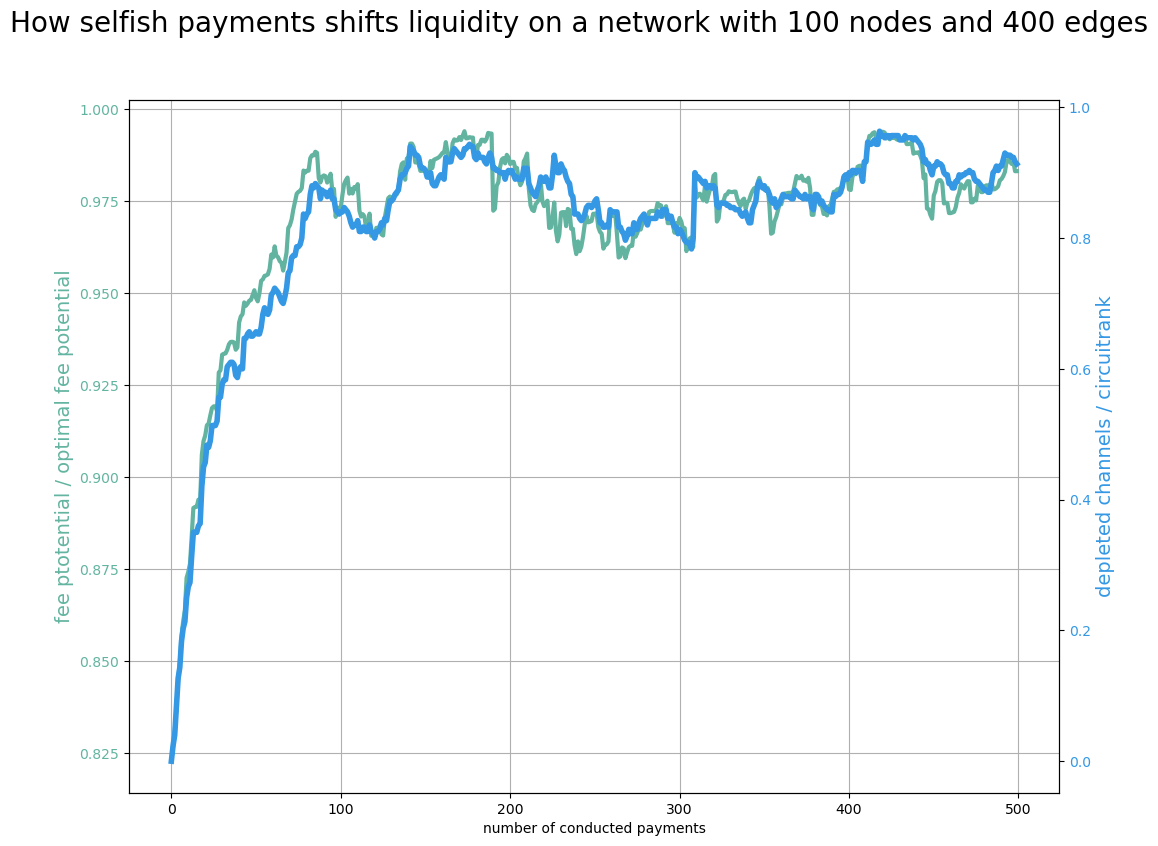

In [78]:
COLOR_FEE_POTENTIAL = "#62b4a0"
COLOR_CIRCUIT_RANK = "#3498e5"

fig, ax1 = plt.subplots(figsize=(12, 9))
ax2 = ax1.twinx()

ax1.plot(fp, color=COLOR_FEE_POTENTIAL, lw=3)
ax2.plot(cr, color=COLOR_CIRCUIT_RANK, lw=4)

ax1.set_xlabel("number of conducted payments")
ax1.set_ylabel("fee ptotential / optimal fee potential", color=COLOR_FEE_POTENTIAL, fontsize=14)
ax1.tick_params(axis="y", labelcolor=COLOR_FEE_POTENTIAL)

ax2.set_ylabel("depleted channels / circuitrank", color=COLOR_CIRCUIT_RANK, fontsize=14)
ax2.tick_params(axis="y", labelcolor=COLOR_CIRCUIT_RANK)

fig.suptitle("How selfish payments shifts liquidity on a network with {} nodes and {} edges".format(n,m), fontsize=20)
ax1.grid()
plt.show()

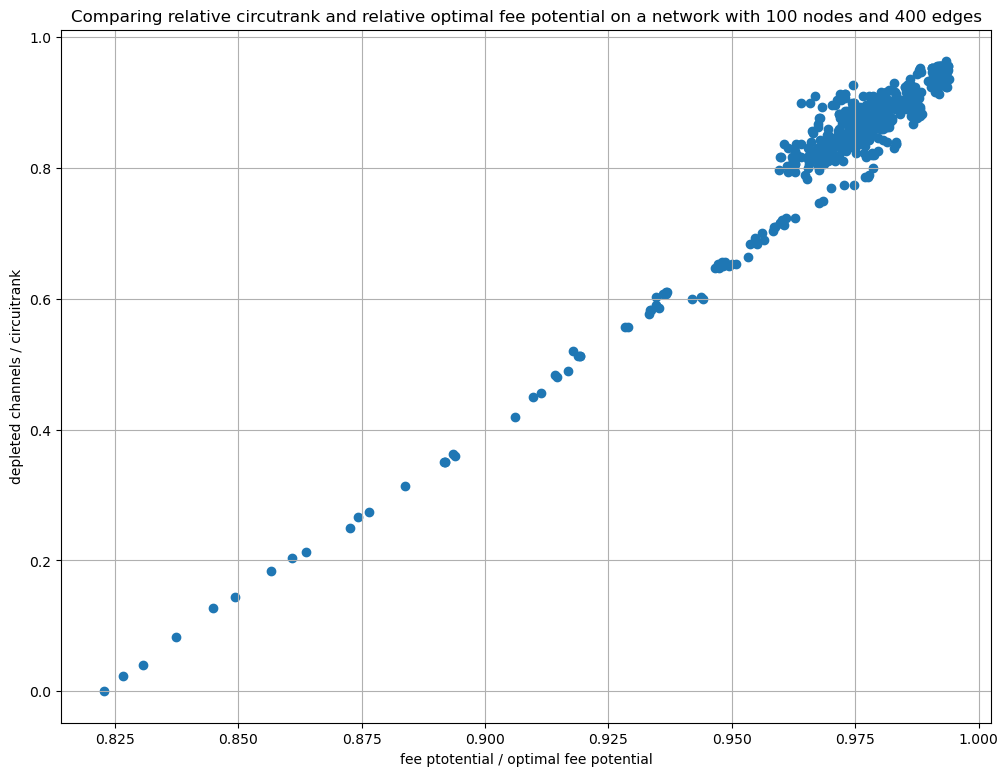

In [80]:
plt.figure(figsize=(12,9))
plt.title("Comparing relative circutrank and relative optimal fee potential on a network with {} nodes and {} edges".format(n,m))
plt.scatter(fp,cr)
plt.grid()
plt.xlabel("fee ptotential / optimal fee potential")
plt.ylabel("depleted channels / circuitrank")
plt.show()

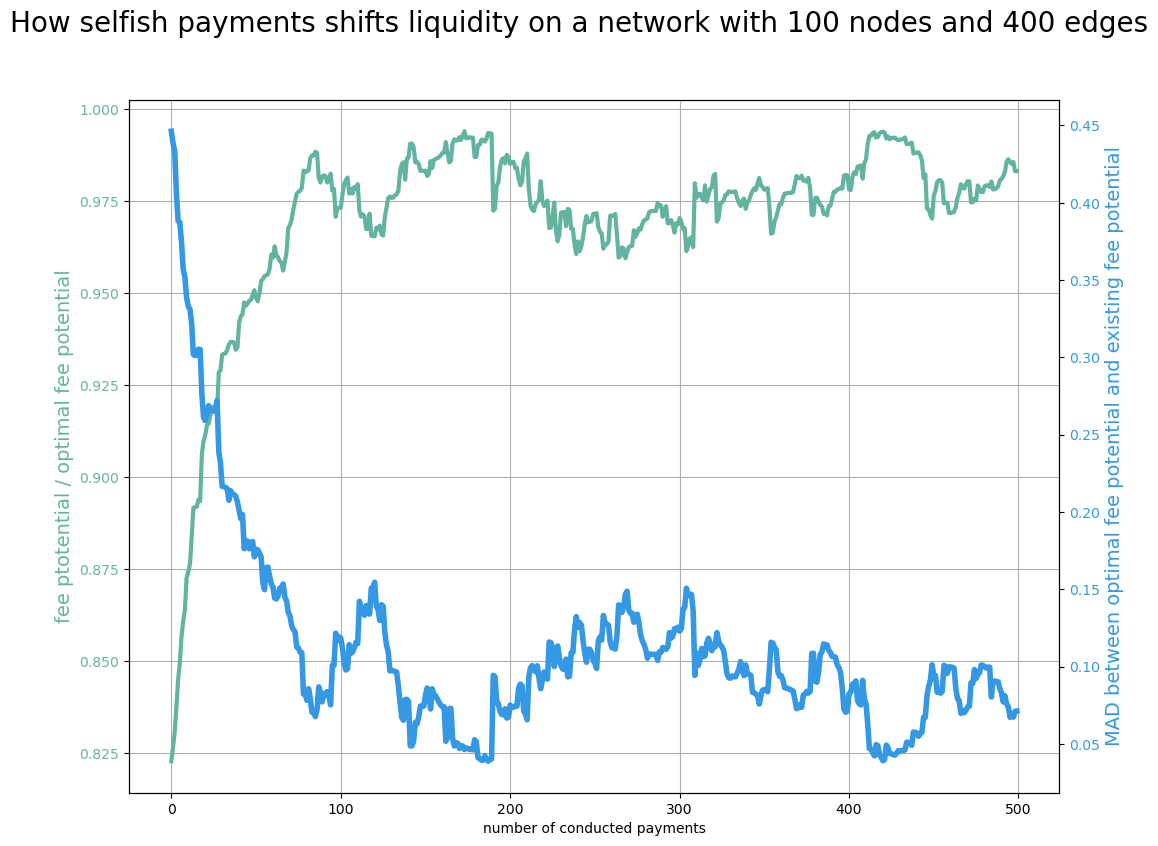

In [82]:
COLOR_FEE_POTENTIAL = "#62b4a0"
COLOR_CIRCUIT_RANK = "#3498e5"

fig, ax1 = plt.subplots(figsize=(12, 9))
ax2 = ax1.twinx()

ax1.plot(fp, color=COLOR_FEE_POTENTIAL, lw=3)
ax2.plot(dist, color=COLOR_CIRCUIT_RANK, lw=4)

ax1.set_xlabel("number of conducted payments")
ax1.set_ylabel("fee ptotential / optimal fee potential", color=COLOR_FEE_POTENTIAL, fontsize=14)
ax1.tick_params(axis="y", labelcolor=COLOR_FEE_POTENTIAL)

ax2.set_ylabel("MAD between optimal fee potential and existing fee potential", color=COLOR_CIRCUIT_RANK, fontsize=14)
ax2.tick_params(axis="y", labelcolor=COLOR_CIRCUIT_RANK)

fig.suptitle("How selfish payments shifts liquidity on a network with {} nodes and {} edges".format(n,m), fontsize=20)
ax1.grid()
plt.show()

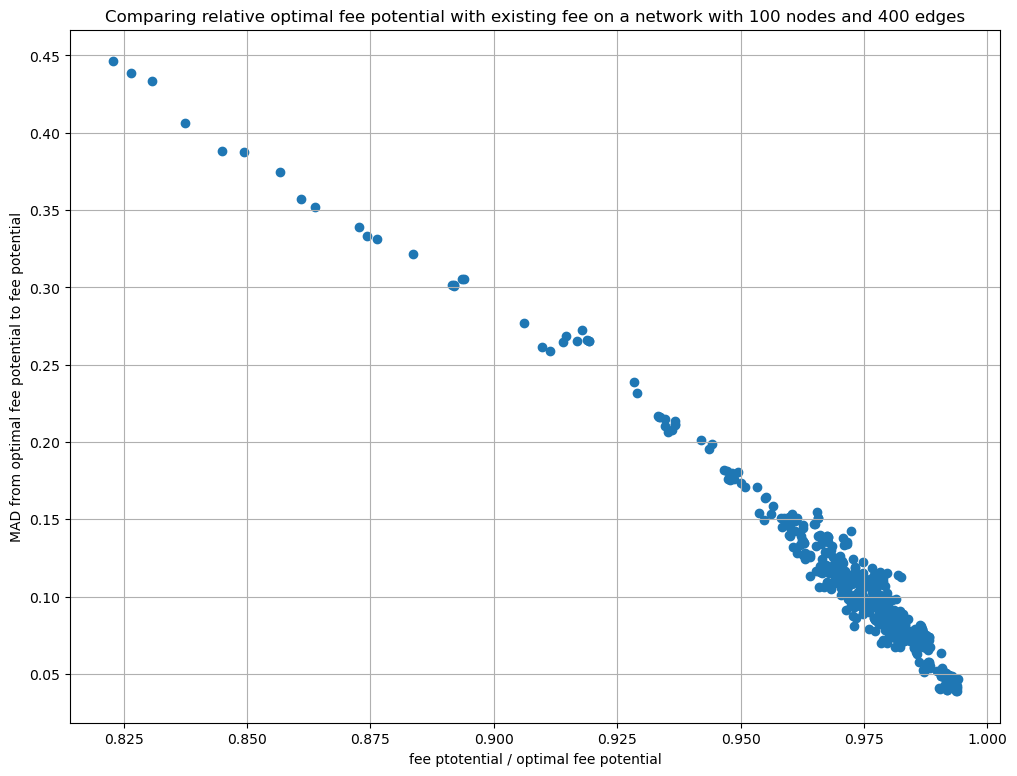

In [84]:
plt.figure(figsize=(12,9))
plt.title("Comparing relative optimal fee potential with existing fee on a network with {} nodes and {} edges".format(n,m))
plt.scatter(fp,dist)
plt.grid()
plt.xlabel("fee ptotential / optimal fee potential")
plt.ylabel("MAD from optimal fee potential to fee potential")
plt.show()